## Simulate with [2, 2, 1] KAN trees usig Jithin's SimpleFNN

In [16]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt



# Network configuration variables
num_gaussians = 1
num_sigmoids = 1
num_layers = 2
output_size = 1

**Scratch that!! Mpt a tree!!** <br>
> __[https://chatgpt.com/share/698bac92-27f8-800a-87ff-267ed968de38]__

In [21]:
# a single layer algorithm
class TreeFrame(nn.Module):
    def __init__(self,input_size, num_gaussians,num_sigmoids, output_size):
        super(TreeFrame, self).__init__()
        self.input_size = input_size
        self.num_gaussians = num_gaussians
        self.num_sigmoids = num_sigmoids

        if self.num_gaussians > 0:
            self.means = nn.Parameter(torch.randn(input_size, num_gaussians)) # means for gaussians tensor
            self.log_sigmas = nn.Parameter(torch.randn(input_size, num_gaussians)/4) # to keep initial standard deviation reasonable
        
        if self.num_sigmoids > 0:
            self.origins = nn.Parameter(torch.randn(input_size, num_sigmoids)) # origins for sigmoids tensor
            self.scales = nn.Parameter(torch.randn(input_size, num_sigmoids)/4) # to keep initial scales reasonable
        
        self.linear = nn.Linear(input_size*(num_gaussians+num_sigmoids), output_size) # linear layer | input size: (# gauss + # sigm) * size_dimention
        self.init_weights() # initialize weights
        
    def init_weights(self):
        nn.init.normal_(self.linear.weight, mean=0, std=1) # initialize weights
        nn.init.normal_(self.linear.bias, mean=0, std=1) # initialize bias
        self.linear.weight.data.clamp_(-1, 1) # set boundry on weights

    def forward(self, x):
        num_points, input_size = x.shape
        x = x.unsqueeze(-1) # change x to be of shape (batch_size, input_size, 1)

        if self.num_gaussians > 0:
            sigma = torch.exp(self.log_sigmas).unsqueeze(0) # shape (1, input_size, num_gaussians)
            mu = self.means.unsqueeze(0) 
            gaussian = torch.exp(-0.5 * ((x - mu) / sigma)**2) # gaussian function

        if self.num_sigmoids > 0:
            origins = self.origins.unsqueeze(0)
            scales = torch.exp(self.scales).unsqueeze(0)
            sigmoid = 1 / (1 + torch.exp(- ((x - origins) / scales))) # sigmoid function

        features = torch.cat([gaussian, sigmoid], dim=-1) # concatenate two tensors horizontally
        features = features.reshape(num_points, -1) # reshape to (batch_size, num_gaussians + num_sigmoids)
        return self.linear(features)

**When is forward called?** <br>
- pytorch calls forward every time when TreeFrame is called
- In this code, the line "y_pred=neural_net(x_eval)" is actually doing "y_pred=neural_net.forward(x_eval)"

In [18]:
# turning the single layer algorithm into a stacked layers algorithm
class SimpleFNN(nn.Module):
    def __init__(self, input_size, num_layers, num_gaussians,num_sigmoids, layer_size, output_size):
        super(SimpleFNN, self).__init__()
        self.layers = nn.ModuleList()

        # First layer
        self.layers.append(TreeFrame(input_size, num_gaussians, num_sigmoids, layer_size))

        # Hidden layers
        for i in range(num_layers - 1):
            self.layers.append(TreeFrame(layer_size, num_gaussians, num_sigmoids, layer_size))

        # Final layer
        self.layers.append(TreeFrame(layer_size, num_gaussians, num_sigmoids, output_size))

    def forward(self, x):
        x = x.view(x.shape[0], -1) # x shape: (batch_size, input_size)
        for layer in self.layers:
            x = layer(x)
        return x

**Gaussian Function**

In [19]:
def gaussian(x, mu, sigma):
    return torch.exp(-0.5 * ((x - mu) / sigma)**2) # mu: mean, sigma: standard deviation

In [23]:
neural_net = SimpleFNN(input_size=2, num_layers=2, num_gaussians=1,num_sigmoids=1, layer_size=4, output_size=1)

x_eval = torch.linspace(-1, 1, 100).unsqueeze(1) # shape (100, 1)  [unsqueeze to add feature dimension]
optimizer = optim.Adam(neural_net.parameters(), lr=1e-3) # Adam optimizer at learning rate 0.001
criterion = nn.MSELoss() # Mean Squared Error loss  [how far your model’s predictions are from the target values]

previous_loss = 100
for epoch in range(1000000):
    optimizer.zero_grad() # zero the parameter gradients
    y_pred = neural_net(x_eval) # forward is called when this line is executed
    y_true = gaussian(x_eval, 0, 1) # target function: y = e^[-0.5 * ((x- mean)/ std dev)^2]  {gaussian}
    #l1_norm = torch.norm(neural_net.fc2.weight, 1) # computes the sum of absolute values of all weights in fc2
    loss = criterion(y_pred, y_true)# + torch.tensor(0.002)*l1_norm
    loss.backward() # backpropagation  [looks at how the loss changes nd calculates how each weight contributed to that loss]
    optimizer.step() # update weights based on gradients calculated during backpropagation

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.6f}")
        print("Amplitudes:", neural_net.layers[-1])
        current_loss = loss
        previous_loss = loss

Epoch 0, Loss 4.479746
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 10000, Loss 0.000004
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 20000, Loss 0.000000
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 30000, Loss 0.000000
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 40000, Loss 0.000000
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 50000, Loss 0.000000
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 60000, Loss 0.000001
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 70000, Loss 0.000000
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 80000, Loss 0.000000
Amplitudes: TreeFrame(
  (linear): Linear(in_features=8, out_features=1, 

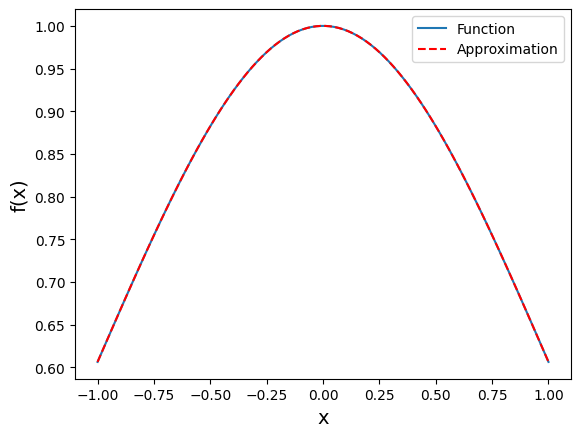

In [24]:
k = 1
y_true = gaussian(x_eval, 0, 1)

plt.plot(k*x_eval, y_true.detach().numpy(),label = 'Function')
plt.plot(k*x_eval, neural_net(k*x_eval).detach().numpy(), 'r--', label = 'Approximation') # passed input through neural network training
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend()

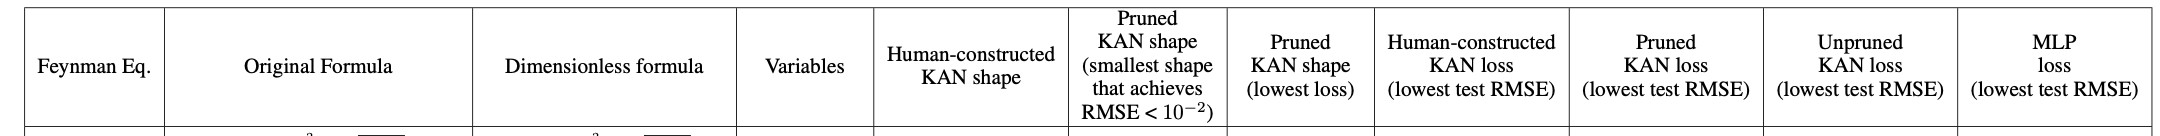
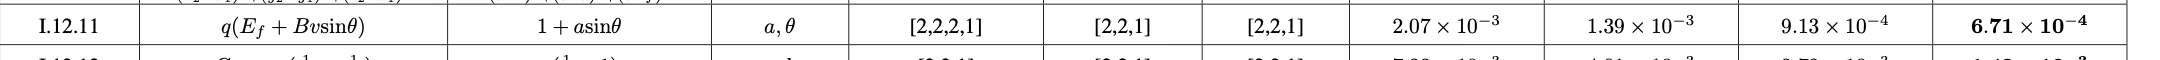

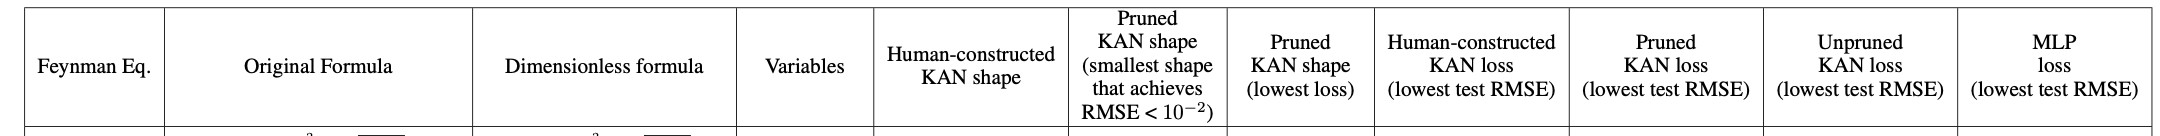
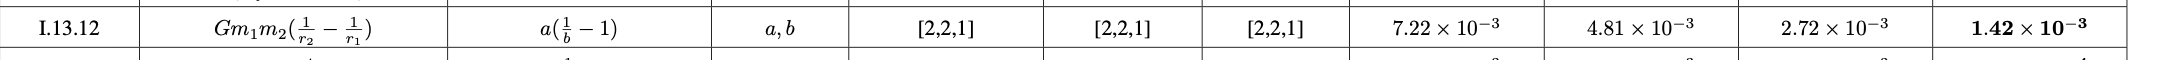

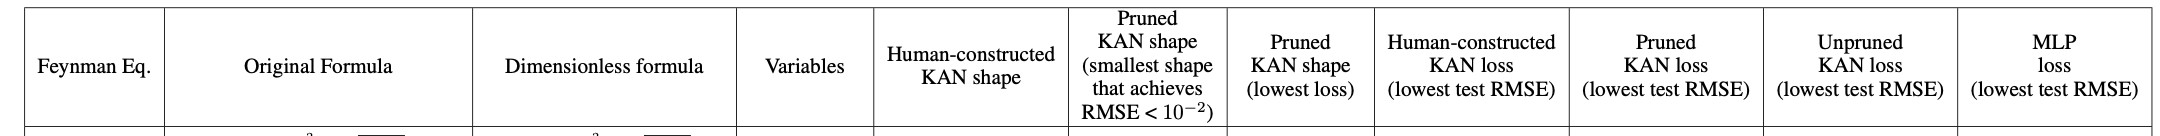
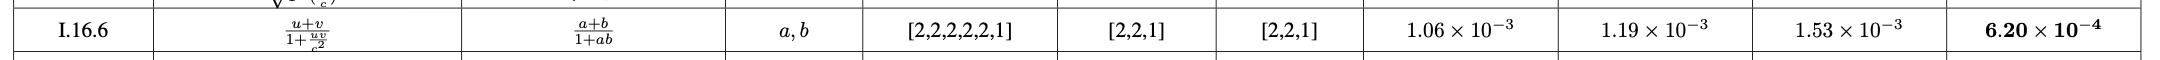

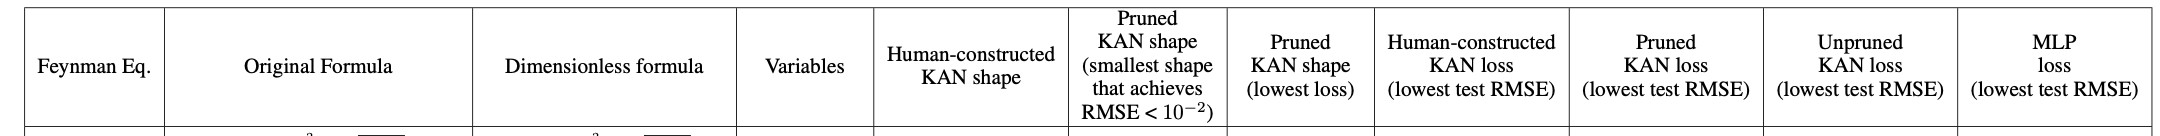
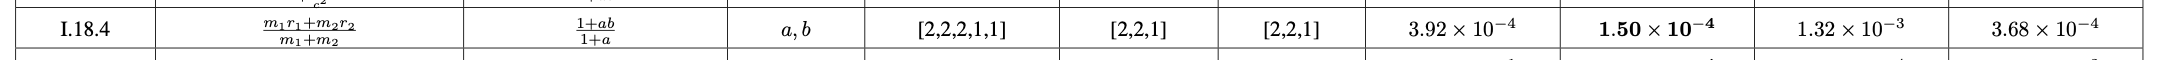

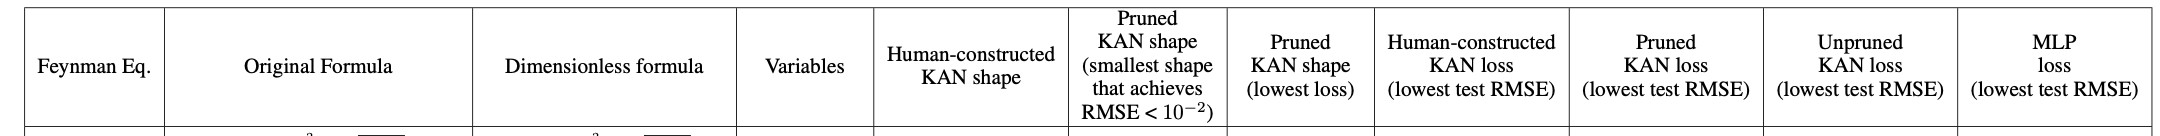
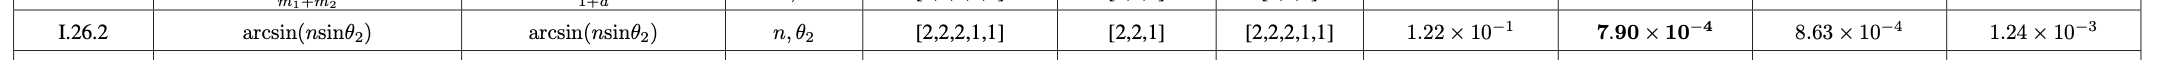

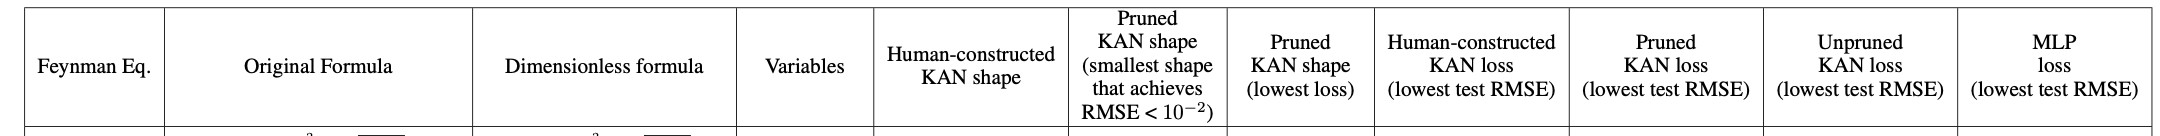
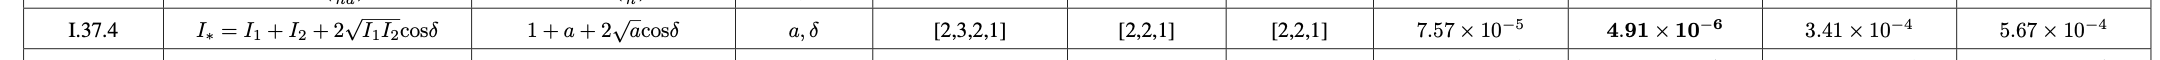

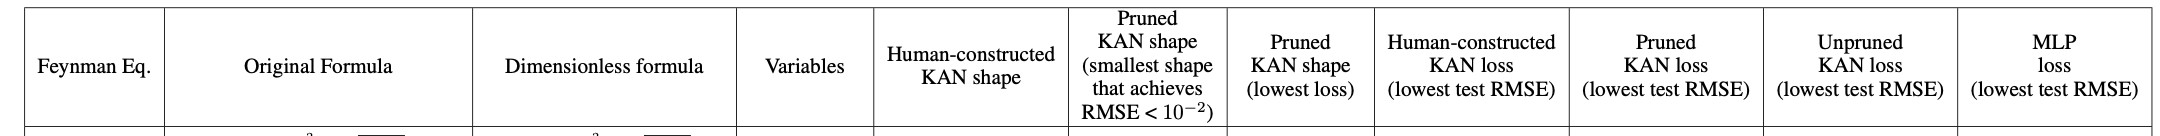
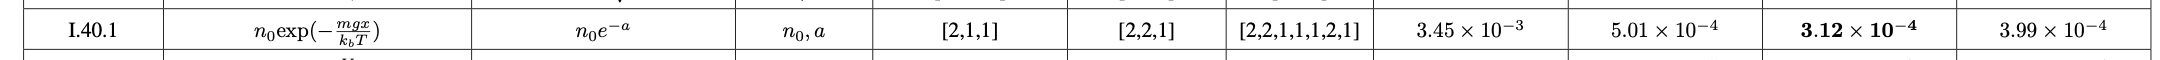

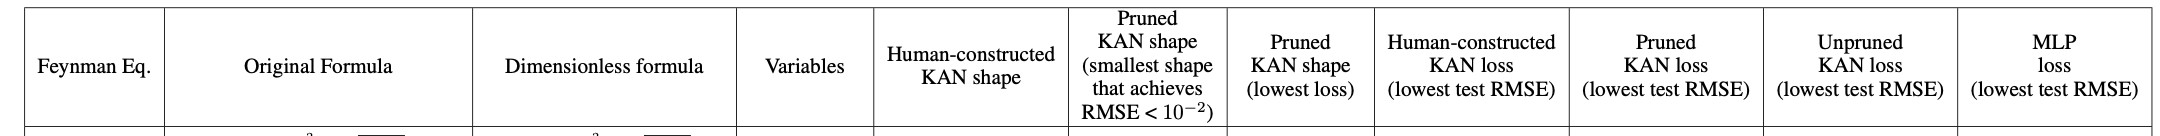
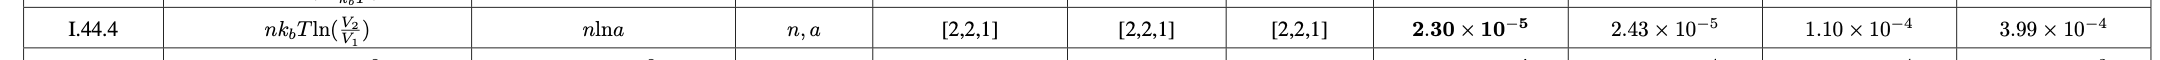

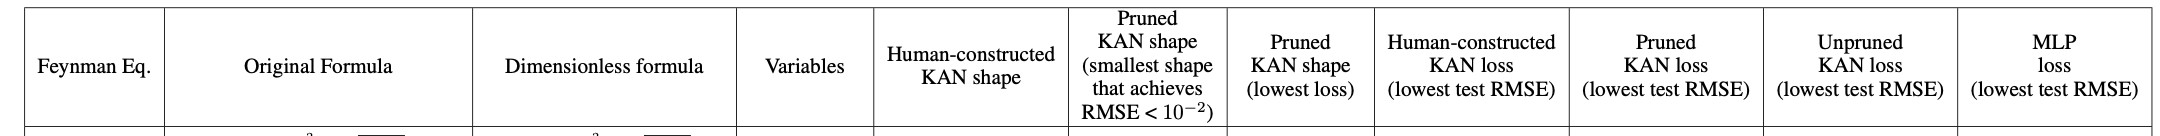
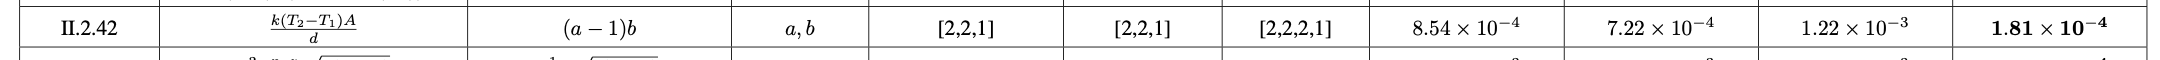